## PMEL ERDDAP M2 Data Visualization

__pyversion__==3.6   
__author__==S.Bell

In [1]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2020-07-14 14:50:50.027552


In [11]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

%matplotlib inline

#server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
server_url='http://ferret.pmel.noaa.gov/pmel/erddap'
e = ERDDAP(server=server_url)

df = pd.read_csv(e.get_search_url(response='csv', search_for='EcoFOCI'))
print(df['Dataset ID'].values)

['EcoFOCI_Bering_Sea_timeseries_data' 'ChukchiSea_454a_037a_fcf4'
 'arcticRescueData_e5bf_cef8_3f72' 'Shelikof_line8_3695_0ada_d066'
 'dy1104_profile_data' 'dy1408_profile_data' 'mf0904_profile_data']


In [3]:
dataset_id = 'EcoFOCI_Bering_Sea_timeseries_data'

### retrieving and plotting data

In [4]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -180.0,
    'max_lon': -130.0,
    'min_lat': 55.0,
    'max_lat': 90.0,
    'min_time': '2010-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z',
}

constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

variables =  e.get_var_by_attr(dataset_id=dataset_id, standard_name=lambda v: v is not 'NC_GLOBAL')
while 'NC_GLOBAL' in variables: variables.remove('NC_GLOBAL')
    
download_url = e.get_download_url(
    dataset_id=dataset_id,
    protocol='tabledap',
    response='csv',
    variables=variables,
)

print(download_url)

http://ferret.pmel.noaa.gov/pmel/erddap/tabledap/EcoFOCI_Bering_Sea_timeseries_data.csv?longitude,ocean_velocity_u_eastward_true_north,ocean_current_speed_component,ocean_chlorophyll_fluorescence_raw,time,ocean_practical_salinity_1,depth,ocean_chlorophyll_a_concentration_factoryCal,ocean_oxygen_saturation_1,ocean_velocity_v_northward_true_north,id,ocean_conductivity_1,latitude,lon360,photosynthetically_active_radiation_raw,ocean_current_direction_component_true_north,ocean_dissolved_oxygen_concentration_1_mMperkg,photosynthetically_active_radiation,ocean_chlorophyll_fluorescence_raw_standard_deviation,ocean_depth,ocean_temperature_1,ocean_turbidity_FNU


In [26]:
from requests.exceptions import HTTPError

dfs = {}
try:
    e = ERDDAP(server=server_url,
        protocol='tabledap',
        response='csv'
    )
    e.variables=variables
    e.dataset_id=dataset_id
except HTTPError:
    print('Failed to generate url {}'.format(dataset_id))

try:
    df_m = e.to_pandas(
                        index_col='time (UTC)',
                        parse_dates=True,
                        skiprows=(1,)  # units information can be dropped.
                        )
    df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]
    dfs.update({dataset_id: df_m})
except:
    pass

In [27]:
dfs

{'EcoFOCI_Bering_Sea_timeseries_data':                            longitude  ocean_velocity_u_eastward_true_north  \
 time (UTC)                                                                   
 2010-10-05 04:00:00+00:00  -164.0622                             15.308270   
 2010-10-05 05:00:00+00:00  -164.0622                              7.269220   
 2010-10-05 06:00:00+00:00  -164.0622                             -5.364515   
 2010-10-05 07:00:00+00:00  -164.0622                            -12.402630   
 2010-10-05 08:00:00+00:00  -164.0622                            -15.250890   
 ...                              ...                                   ...   
 2017-04-16 07:00:00+00:00  -164.0510                             17.813100   
 2017-04-16 08:00:00+00:00  -164.0510                             16.771500   
 2017-04-16 09:00:00+00:00  -164.0510                             16.068900   
 2017-04-16 10:00:00+00:00  -164.0510                             11.752300   
 2017-04-16 11

KeyError: 'depth'

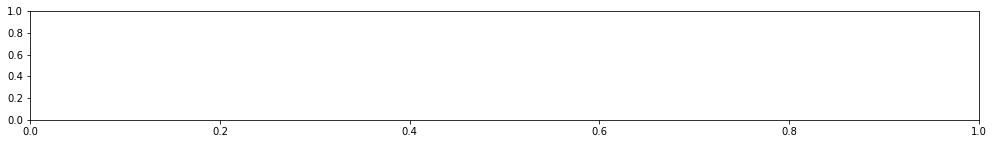

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['depth'], s=15, c=df['ocean_temperature_1'], marker='o', edgecolor='none', vmin=-2, vmax=10, cmap=cmocean.cm.thermal)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)
    #fig.savefig(dfn+'.png',dpi=300)

In [7]:
for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['depth'], s=15, c=df['ocean_practical_salinity_1'], marker='o', edgecolor='none', vmin=31, vmax=33, cmap=cmocean.cm.haline)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Salinity (PSU)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)
    
    #fig.savefig(dfn+'.png',dpi=300)

In [12]:
for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['depth'], s=15, c=df['ocean_chlorophyll_a_concentration_factoryCal'], marker='o', edgecolor='none', vmin=0, vmax=15, cmap=cmocean.cm.algae)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Salinity (PSU)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

    #fig.savefig(dfn+'.png',dpi=300)